# Лекция 7. Кодирование и отбор признаков. Кросс-валидация.

In [33]:
from IPython.display import Image
import pandas as pd #pip install pandas/openpyxl
import re
from sklearn.model_selection import train_test_split #pip install scikit-learn
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go #pip install plotly
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import cross_validate
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [16]:
laptops=pd.read_csv('/content/drive/MyDrive/Введение в ML ITHUB/lessons/data/laptop_price.csv',encoding='Windows-1251')
laptops.head(10)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
5,6,Acer,Aspire 3,Notebook,15.6,1366x768,AMD A9-Series 9420 3GHz,4GB,500GB HDD,AMD Radeon R5,Windows 10,2.1kg,400.00
6,7,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.2GHz,16GB,256GB Flash Storage,Intel Iris Pro Graphics,Mac OS X,2.04kg,2139.97
7,8,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,256GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,1158.70
8,9,Asus,ZenBook UX430UN,Ultrabook,14.0,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,16GB,512GB SSD,Nvidia GeForce MX150,Windows 10,1.3kg,1495.00
9,10,Acer,Swift 3,Ultrabook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,Intel UHD Graphics 620,Windows 10,1.6kg,770.00


Результирующая переменная - Price_euros. Будем предсказывать цену ноутбука по его характеристикам.

In [17]:
#предобработка с прошлых занятий
laptops['Weight']=laptops['Weight'].str.replace('kg','').astype('float64')
ssd=[]
hdd=[]
fs=[]
for i in laptops['Memory']:
    if 'SSD' in i:
        ssd.append(1)
        hdd.append(0)
        fs.append(0)
    elif 'HDD' in i:
        ssd.append(0)
        hdd.append(1)
        fs.append(0)
    else:
        ssd.append(0)
        hdd.append(0)
        fs.append(1)
laptops['ssd']=ssd
laptops['hdd']=hdd
laptops['fs']=fs
s = [float(re.findall(r'\d+', s)[0]) for s in laptops['Memory']]
laptops['Memory']=s
laptops['Ram']=laptops['Ram'].str.replace('GB','').astype('int32')
laptops.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,ssd,hdd,fs
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128.0,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,1,0,0
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128.0,Intel HD Graphics 6000,macOS,1.34,898.94,0,0,1
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256.0,Intel HD Graphics 620,No OS,1.86,575.00,1,0,0
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512.0,AMD Radeon Pro 455,macOS,1.83,2537.45,1,0,0
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256.0,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,1,0,0


In [18]:
laptops_m1 = laptops[['Inches','Memory','Weight','ssd','hdd','fs','Ram','Price_euros']]
X=laptops_m1.drop(['Price_euros'],axis=1)
Y=laptops_m1['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)

In [ ]:
#mape
print(round(mean_absolute_percentage_error(y_test,y_pred),2))

## Кодирование категориальных признаков


In [19]:
#работаем с компанией
laptops['Company'].value_counts()

Dell         297
Lenovo       297
HP           274
Asus         158
Acer         103
MSI           54
Toshiba       48
Apple         21
Samsung        9
Razer          7
Mediacom       7
Microsoft      6
Xiaomi         4
Vero           4
Chuwi          3
Google         3
Fujitsu        3
LG             3
Huawei         2
Name: Company, dtype: int64

In [9]:
#one-hot encoding
Image(url="https://cdn-images-1.medium.com/fit/t/1600/480/1*ggtP4a5YaRx6l09KQaYOnw.png")

In [23]:
ohe_company = OneHotEncoder()
companies = ohe_company.fit_transform(laptops[['Company']])
companies.toarray()

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [24]:
#превращаем массив в датафрейм
companies=pd.DataFrame(companies.toarray(), columns=ohe_company.get_feature_names_out())
companies.head(10)

,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Fujitsu,Company_Google,Company_HP,Company_Huawei,Company_LG,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Microsoft,Company_Razer,Company_Samsung,Company_Toshiba,Company_Vero,Company_Xiaomi
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
companies.shape

(1303, 19)

In [25]:
laptops_m2 = pd.concat([laptops_m1,companies],axis=1)
laptops_m2.head()

,Inches,Memory,Weight,ssd,hdd,fs,Ram,Price_euros,Company_Acer,Company_Apple,...,Company_LG,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Microsoft,Company_Razer,Company_Samsung,Company_Toshiba,Company_Vero,Company_Xiaomi
0,13.3,128.0,1.37,1,0,0,8,1339.69,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13.3,128.0,1.34,0,0,1,8,898.94,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15.6,256.0,1.86,1,0,0,8,575.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15.4,512.0,1.83,1,0,0,16,2537.45,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13.3,256.0,1.37,1,0,0,8,1803.60,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
X=laptops_m2.drop(['Price_euros'],axis=1)
Y=laptops_m2['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)
print(round(mean_absolute_percentage_error(y_test,y_pred),2))

0.31


In [27]:
#закодировать остальные категориальные переменные
ohe_opsys = OneHotEncoder()
opsys = ohe_opsys.fit_transform(laptops[['OpSys']])
opsys=pd.DataFrame(opsys.toarray(), columns=ohe_opsys.get_feature_names_out())
opsys.head()

,OpSys_Android,OpSys_Chrome OS,OpSys_Linux,OpSys_Mac OS X,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [29]:
ohe_tn = OneHotEncoder()
tn = ohe_tn.fit_transform(laptops[['TypeName']])
tn=pd.DataFrame(tn.toarray(), columns=ohe_tn.get_feature_names_out())
tn.head()

,TypeName_2 in 1 Convertible,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation
0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
laptops_m3 = pd.concat([laptops_m2,opsys,tn],axis=1)
laptops_m3.head()

,Inches,Memory,Weight,ssd,hdd,fs,Ram,Price_euros,Company_Acer,Company_Apple,...,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS,TypeName_2 in 1 Convertible,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation
0,13.3,128.0,1.37,1,0,0,8,1339.69,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,13.3,128.0,1.34,0,0,1,8,898.94,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,15.6,256.0,1.86,1,0,0,8,575.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,15.4,512.0,1.83,1,0,0,16,2537.45,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,13.3,256.0,1.37,1,0,0,8,1803.60,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [32]:
X=laptops_m3.drop(['Price_euros'],axis=1)
Y=laptops_m3['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)
print(round(mean_absolute_percentage_error(y_test,y_pred),2))

0.27


In [35]:
true_vs_pred = pd.DataFrame({'Истинные': y_test, 'Предсказанные': y_pred})
random_x = np.linspace(0, len(true_vs_pred['Истинные']))

fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=true_vs_pred['Истинные'],
                    mode='lines',
                    name='истинные'))
fig.add_trace(go.Scatter(x=random_x, y=true_vs_pred['Предсказанные'],
                    mode='lines+markers',
                    name='предсказанные'))

fig.show()

## отбор признаков

Прекрасный курс по статистике - https://stepik.org/course/76/syllabus

Прекрасные книги для погружения в статистику - "Статистика и котики", "Голая статистика"

Корреляционный анализ.Простыми словами корреляция – это взаимосвязь двух или нескольких случайных параметров. Когда одна величина растет или уменьшается, другая тоже изменяется.

In [36]:
#корреляционный анализ
Image(url='https://i2.wp.com/advi.club/uploads/posts/2018-06/1528301810_korelacionniy-analiz.jpg')

In [37]:
#коэффициент корреляции пирсона
Image(url='https://ktonanovenkogo.ru/image/koeffitcient-korreliatcii-formula.jpg')

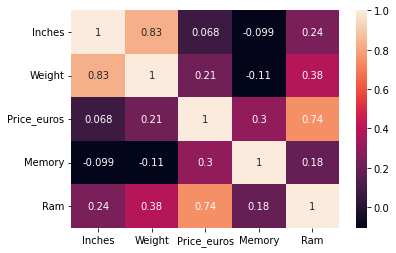

In [39]:
cols = ['Inches','Weight','Price_euros','Memory','Ram']
hm = sns.heatmap(laptops_m2[cols].corr(),
                 cbar=True,
                 annot=True)

от -1 до 1:
* >0,5 - имеется значительная
* >0.8 - корреляция классная

In [ ]:
#laptops_m3=laptops_m3.drop(['Inches','Weight'],axis=1)
X=laptops_m3.drop(['Price_euros'],axis=1)
Y=laptops_m3['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)
print(round(mean_absolute_percentage_error(y_test,y_pred),2))

In [42]:
model=sm.OLS(laptops_m3['Ram'],laptops_m3['Price_euros'])
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    Ram   R-squared (uncentered):                   0.864
Model:                            OLS   Adj. R-squared (uncentered):              0.864
Method:                 Least Squares   F-statistic:                              8279.
Date:                Fri, 17 Mar 2023   Prob (F-statistic):                        0.00
Time:                        02:36:58   Log-Likelihood:                         -3522.9
No. Observations:                1303   AIC:                                      7048.
Df Residuals:                    1302   BIC:                                      7053.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Price_euros     0.0069   7.57e-05     90.989      0.000       0.007       0.007
==============================================================================
Omnibus:                      361.011   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6624.958
Skew:                           0.798   Prob(JB):                         0.00
Kurtosis:                      13.930   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
#однофакторные модели
Y=laptops_m3[['Price_euros']]
X=laptops_m3.drop(['Price_euros'],axis=1)
df_feats_znach = pd.DataFrame(columns=['feature','pvalue','coef'])
for c in X.columns:
    para=pd.concat((X[c],Y),axis=1)
    para.dropna(inplace=True)
    para.columns=['x','y']
    try:
        model=sm.OLS(para['y'],para['x'])
        result=model.fit()
        pval=result.pvalues
        coefs=result.params
        if pval[0]<0.05:
            df_feats_znach.loc[len(df_feats_znach)]=[c,pval[0],coefs[0]]
        else:
            continue
    except:
        print(c)

In [45]:
df_feats_znach.sort_values(by='coef',ascending=False)

,feature,pvalue,coef
15,Company_Razer,1.527964e-11,3346.142857
31,TypeName_Workstation,3.941561e-21,2280.358966
11,Company_LG,5.960817e-03,2099.000000
25,OpSys_macOS,1.704077e-06,1749.630769
27,TypeName_Gaming,7.944458e-91,1731.380634
13,Company_MSI,1.477709e-22,1728.908148
24,OpSys_Windows 7,4.343674e-18,1686.651333
9,Company_Google,2.803614e-02,1677.666667
14,Company_Microsoft,2.807753e-03,1612.308333
6,Company_Apple,5.184138e-08,1564.198571


In [46]:
df_feats_znach['feature'].values

array(['Memory', 'ssd', 'hdd', 'fs', 'Ram', 'Company_Acer',
       'Company_Apple', 'Company_Asus', 'Company_Dell', 'Company_Google',
       'Company_HP', 'Company_LG', 'Company_Lenovo', 'Company_MSI',
       'Company_Microsoft', 'Company_Razer', 'Company_Samsung',
       'Company_Toshiba', 'OpSys_Chrome OS', 'OpSys_Linux',
       'OpSys_Mac OS X', 'OpSys_No OS', 'OpSys_Windows 10',
       'OpSys_Windows 10 S', 'OpSys_Windows 7', 'OpSys_macOS',
       'TypeName_2 in 1 Convertible', 'TypeName_Gaming',
       'TypeName_Netbook', 'TypeName_Notebook', 'TypeName_Ultrabook',
       'TypeName_Workstation'], dtype=object)

In [47]:
laptops_m4=laptops_m3[list(df_feats_znach['feature'].values)]
laptops_m4.head()

,Memory,ssd,hdd,fs,Ram,Company_Acer,Company_Apple,Company_Asus,Company_Dell,Company_Google,...,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS,TypeName_2 in 1 Convertible,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation
0,128.0,1,0,0,8,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,128.0,0,0,1,8,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,256.0,1,0,0,8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,512.0,1,0,0,16,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,256.0,1,0,0,8,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [48]:
X=laptops_m4
Y=laptops_m3['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)
print(round(mean_absolute_percentage_error(y_test,y_pred),2))

0.27


In [49]:
true_vs_pred = pd.DataFrame({'Истинные': y_test, 'Предсказанные': y_pred})

In [50]:
random_x = np.linspace(0, len(true_vs_pred['Истинные']))

fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=true_vs_pred['Истинные'],
                    mode='lines',
                    name='lines'))
fig.add_trace(go.Scatter(x=random_x, y=true_vs_pred['Предсказанные'],
                    mode='lines+markers',
                    name='lines+markers'))

fig.show()

## Кросс-валидация

Кросс-валидация — это методика обучения и оценки модели, которая разбивает данные на несколько секций и обучает несколько алгоритмов на этих секциях.

In [51]:
Image(url='https://wiki.loginom.ru/images/cross-validation.svg')

In [58]:
#параметры - модель,Х,Y, сv(сколько разбиений),scoring - метрики оценки
regressor = LinearRegression()
scores = cross_validate(regressor, X, Y, cv=10,scoring=('neg_mean_absolute_percentage_error'))

In [59]:
scores

{'fit_time': array([0.00768137, 0.006042  , 0.00596046, 0.01301789, 0.01486015,
        0.00600958, 0.00598264, 0.00582027, 0.00586677, 0.00598598]),
 'score_time': array([0.00271702, 0.00300241, 0.00262785, 0.00273585, 0.00302911,
        0.00250387, 0.0024929 , 0.00358224, 0.00262642, 0.00241947]),
 'test_score': array([-0.33143047, -0.28914576, -0.2661307 , -0.27462409, -0.27110925,
        -0.28019032, -0.24616483, -0.21729813, -0.26069228, -0.29684324])}

In [60]:
scores['test_score'].mean().round(2)*-1 #среднее значение метрики на кросс-валидации

0.27

## Лабораторная работа №2

* ищем набор данных, для которого можно решить задачу регрессии (критерии к данным такие же, как в ЛР1)
* провести предобработку признаков и их последующий отбор
* строим модели - минимум 3 различные модели (разный набор признаков, разные алгоритмы)
* с помощью метрик оценить качество полученных моделей на тестовой выборке, выбрать наилучшую
* построить график для тестовых значений (предсказанные с помощью лучшей модели против реальных)

могут быть допбаллы за хорошую многомерную модель